In [14]:
from __future__ import print_function
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import tempfile
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
import urllib
import requests

from tensorflow.keras import layers
from tensorflow.keras import Model


print('Modules are imported.')

Modules are imported.


In [3]:
dogsvcats_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

current_dir = "/Users/dhensle/Documents/kaggle/google_course/"
# req = requests.get(dogsvcats_url)

urllib.request.urlretrieve(dogsvcats_url,current_dir + "/tmp/cats_and_dogs_filtered.zip")

# with open('/tmp/cats_and_dogs_filtered.zip','wb') as code:
#     code.write(req.content)

('/Users/dhensle/Documents/kaggle/google_course//tmp/cats_and_dogs_filtered.zip',
 <http.client.HTTPMessage at 0x1a2c47f400>)

In [4]:
local_zip = current_dir + '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(current_dir + '/tmp')
zip_ref.close()


In [5]:
base_dir = "/Users/dhensle/Documents/kaggle/google_course/tmp/cats_and_dogs_filtered"
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')



In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg', 'cat.985.jpg', 'cat.775.jpg', 'cat.761.jpg', 'cat.588.jpg', 'cat.239.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [8]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [10]:
nrows = 4 # Plot parameters 
ncols = 4
pic_index = 0 # index for iterating over images

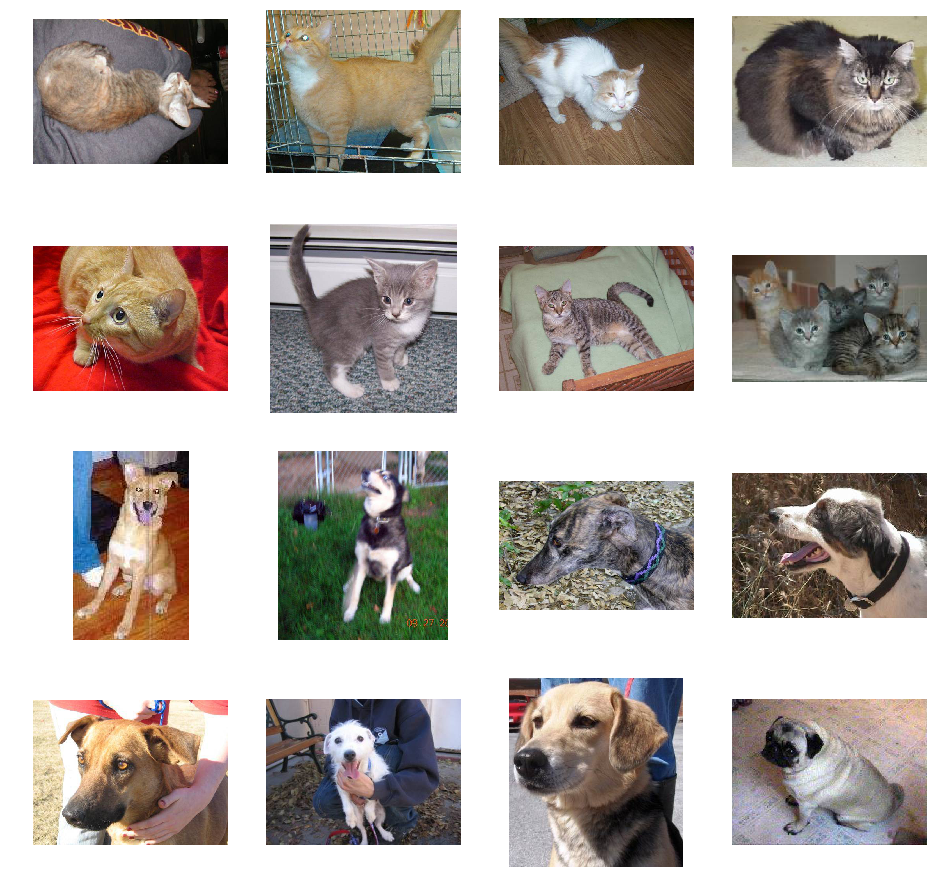

In [48]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
               for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir,fname)
               for fname in train_dog_fnames[pic_index-8:pic_index]]
# print("next_cat_pix = " + next_cat_pix)

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

In [49]:
#images are 150x150 pixels, and 3 for the RGB color channels
img_input = layers.Input(shape=(150,150,3))

#First Conv extracts 16 filters, 3x3 ea followed by max-pooling layer with 2x2 window
x = layers.Conv2D(16,3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#Second Conv extracts 32 filters, 3x3 ea followed by max-pooling layer with 2x2 window
x = layers.Conv2D(32,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Third Conv extracts 64 filters, 3x3 ea followed by max-pooling layer with 2x2 window
x = layers.Conv2D(64,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


In [50]:
#Flatten feature map to 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

#Fully connected layer with reLu activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

#Create output layer with single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

#Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + sigmoid output layer
model = Model(img_input, output)

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 64)        0         
__________

In [52]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=.001),
             metrics=['acc'])

In [53]:
#building generators to yield batches of 20 images of size 150x150 pixels and their binary labels
# also normalizing pixel values from [0,255] to [0,1]

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#All images rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, #source directory
    target_size=(150,150), #Resizing all images to 150x150 pizels
    batch_size=20,
    class_mode='binary'
)

#Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir, #source directory
    target_size=(150,150), #Resizing all images to 150x150 pizels
    batch_size=20,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [54]:
#training on all 2000 images for 15 epochs and validate on all 1000 test images
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=2)

Epoch 1/15
50/50 [==============================] - 8s 157ms/step - loss: 0.6494 - acc: 0.5590
 - 58s - loss: 0.7386 - acc: 0.5645 - val_loss: 0.6494 - val_acc: 0.5590
Epoch 2/15
50/50 [==============================] - 8s 157ms/step - loss: 0.6183 - acc: 0.6720
 - 58s - loss: 0.6340 - acc: 0.6665 - val_loss: 0.6183 - val_acc: 0.6720
Epoch 3/15
50/50 [==============================] - 8s 158ms/step - loss: 0.5653 - acc: 0.7250
 - 58s - loss: 0.5580 - acc: 0.7240 - val_loss: 0.5653 - val_acc: 0.7250
Epoch 4/15
50/50 [==============================] - 8s 150ms/step - loss: 0.5622 - acc: 0.7310
 - 57s - loss: 0.4682 - acc: 0.7840 - val_loss: 0.5622 - val_acc: 0.7310
Epoch 5/15
50/50 [==============================] - 7s 150ms/step - loss: 0.5977 - acc: 0.7040
 - 58s - loss: 0.3830 - acc: 0.8450 - val_loss: 0.5977 - val_acc: 0.7040
Epoch 6/15
50/50 [==============================] - 8s 156ms/step - loss: 0.6723 - acc: 0.7190
 - 55s - loss: 0.2993 - acc: 0.8680 - val_loss: 0.6723 - val_acc:

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


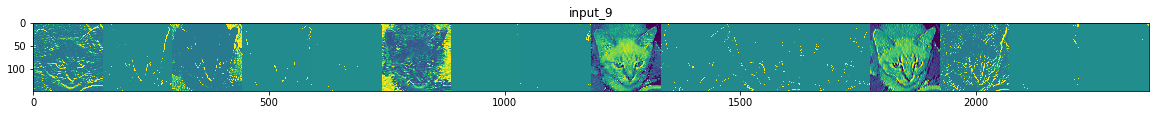

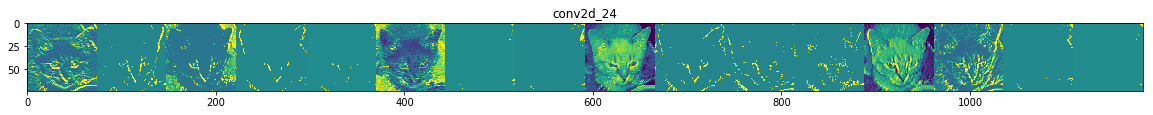

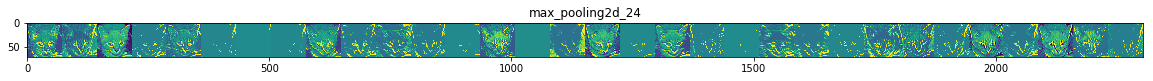

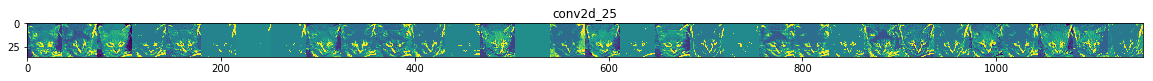

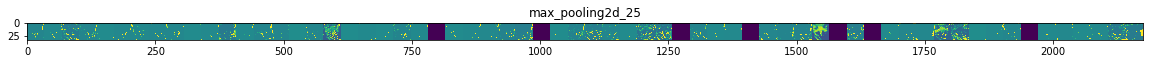

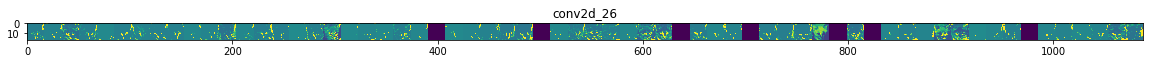

In [57]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#defining new model that will take an image as imput, and output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

#preparing random image of cat or dog from training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir,f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150,150)) #this is a PIL image
x = img_to_array(img) #numpy array with shape (150,150,3)
x = x.reshape((1,)+x.shape) #numpy array with shape (1,150,150,3)
x/= 255

#running the image through the network to obtain all intermediate representations
successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

#displaying representations
for layer_name, feature_map in zip (layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        #just doing conv/maxpool layers, not fully-connected layers
        n_features = feature_map.shape[-1] # number of features in feature map
        size = feature_map.shape[1] # feature map has shape (1, size, size, n_features)
        
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0,:,:,i]
            x -= x.mean()
            x /= x.std()
            x*=64
            x+= 128
            x = np.clip(x,0,255).astype('uint8')
            display_grid[:,i*size:(i + 1) * size] = x
        scale = 20./n_features
        plt.figure(figsize =(scale* n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')
    

Text(0.5, 1.0, 'Trailing and validation loss')

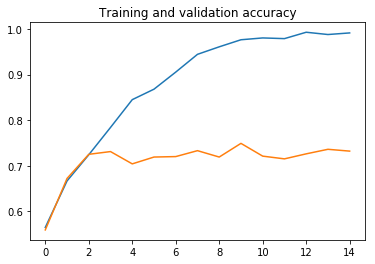

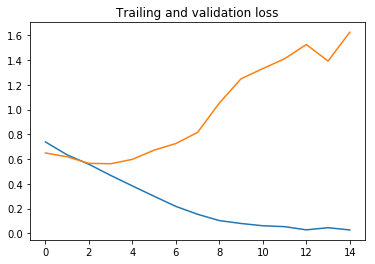

In [59]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')


###### We are overfitting.  Trying two techniques to combat this: data augmentation and dropout regularization

In [60]:
datagen = ImageDataGenerator(
    rotation_range=40, #randomly rotate picture between [0,40] degrees
    width_shift_range=0.2, #translate picture horizontally
    height_shift_range=0.2, #translate picture vertically
    shear_range=0.2, # shear transformation
    zoom_range=0.2, # zooming in on pictures
    horizontal_flip=True, #randomly flips half of the pictures horizontally
    fill_mode='nearest' # strategy for filling in newly created pixels after transformations
)


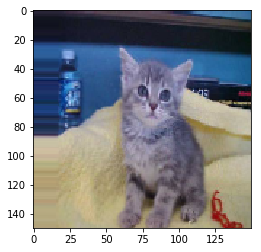

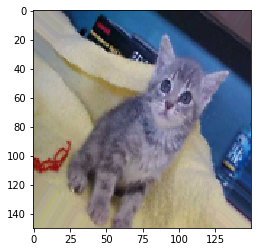

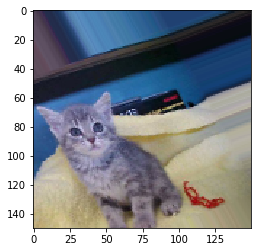

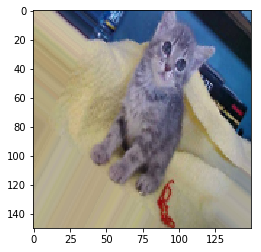

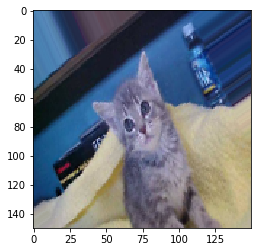

In [63]:
from tensorflow.keras.preprocessing.image import array_to_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[4])
img = load_img(img_path, target_size=(150,150))
x = img_to_array(img) #numpy array with shape (150,150,3)
x = x.reshape((1,) + x.shape) #numpy array with shape (1,150,150,3)

#the .flow() command generates batches of randomly transformed images
#  will loop indefinitely, so need to break
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i+=1
    if i % 5 == 0:
        break

In [65]:
#adding image modification to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

#Validation Data should not be modified!
test_datagen = ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 32
train_generator = train_datagen.flow_from_directory(
    train_dir, #source directory for training images
    target_size=(150,150), #all images resized to 150x150
    batch_size=20,
    class_mode='binary' # need binary labels for binary_crossentropy loss
)

#Flow validation images in batches of 32
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [66]:
#training on all 2000 images for 15 epochs and validate on all 1000 test images
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=2)

Epoch 1/15
50/50 [==============================] - 10s 202ms/step - loss: 0.5639 - acc: 0.6900
 - 72s - loss: 0.7618 - acc: 0.6290 - val_loss: 0.5639 - val_acc: 0.6900
Epoch 2/15
50/50 [==============================] - 9s 177ms/step - loss: 0.5695 - acc: 0.7340
 - 66s - loss: 0.6058 - acc: 0.6790 - val_loss: 0.5695 - val_acc: 0.7340
Epoch 3/15
50/50 [==============================] - 8s 166ms/step - loss: 0.5636 - acc: 0.7480
 - 61s - loss: 0.6242 - acc: 0.6680 - val_loss: 0.5636 - val_acc: 0.7480
Epoch 4/15
50/50 [==============================] - 9s 174ms/step - loss: 0.5253 - acc: 0.7450
 - 61s - loss: 0.5994 - acc: 0.6945 - val_loss: 0.5253 - val_acc: 0.7450
Epoch 5/15
50/50 [==============================] - 10s 205ms/step - loss: 0.5532 - acc: 0.7160
 - 69s - loss: 0.6034 - acc: 0.7055 - val_loss: 0.5532 - val_acc: 0.7160
Epoch 6/15
50/50 [==============================] - 8s 159ms/step - loss: 0.5062 - acc: 0.7530
 - 68s - loss: 0.5994 - acc: 0.6865 - val_loss: 0.5062 - val_ac

Text(0.5, 1.0, 'Trailing and validation loss')

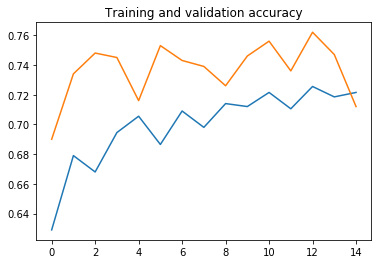

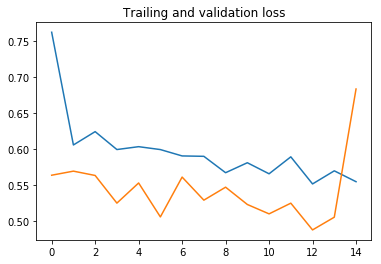

In [67]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')

###### Adding dropout right before final classification layer

In [70]:
#Input feature map is 150x150x3(RGB color)
img_input = layers.Input(shape=(150,150,3))

#first conv extracts 16 filters that are 3x3 followed by 2x2 max-pooling window
x = layers.Conv2D(16,3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#Second conv extracts 32 filters that are 3x3 followed by 2x2 max-pooling window
x = layers.Conv2D(32,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Third conv extracts 64 filters that are 3x3 followed by 2x2 max-pooling window
x = layers.Conv2D(64,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Flatten to 1-dim tensor
x = layers.Flatten()(x)

#create fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

#Dropout layer with rate 0.5
x = layers.Dropout(0.5)(x)

#Output layer with single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=.001),
             metrics=['acc'])

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 17, 17, 64)        0         
__________

In [72]:
#training on all 2000 images for 15 epochs and validate on all 1000 test images
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=2)

Epoch 1/15
50/50 [==============================] - 8s 166ms/step - loss: 0.6863 - acc: 0.5200
 - 64s - loss: 0.7663 - acc: 0.5195 - val_loss: 0.6863 - val_acc: 0.5200
Epoch 2/15
50/50 [==============================] - 12s 234ms/step - loss: 0.6683 - acc: 0.6490
 - 66s - loss: 0.6977 - acc: 0.5455 - val_loss: 0.6683 - val_acc: 0.6490
Epoch 3/15
50/50 [==============================] - 10s 201ms/step - loss: 0.6406 - acc: 0.6120
 - 80s - loss: 0.6872 - acc: 0.5800 - val_loss: 0.6406 - val_acc: 0.6120
Epoch 4/15
50/50 [==============================] - 11s 220ms/step - loss: 0.5869 - acc: 0.7050
 - 75s - loss: 0.6559 - acc: 0.6300 - val_loss: 0.5869 - val_acc: 0.7050
Epoch 5/15
50/50 [==============================] - 9s 185ms/step - loss: 0.6144 - acc: 0.6450
 - 77s - loss: 0.6317 - acc: 0.6440 - val_loss: 0.6144 - val_acc: 0.6450
Epoch 6/15
50/50 [==============================] - 10s 202ms/step - loss: 0.5885 - acc: 0.6940
 - 76s - loss: 0.6347 - acc: 0.6430 - val_loss: 0.5885 - val_

Text(0.5, 1.0, 'Trailing and validation loss')

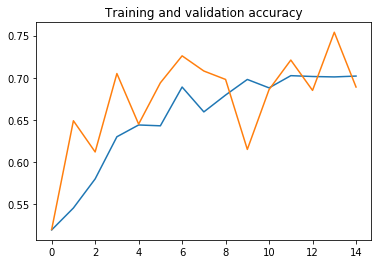

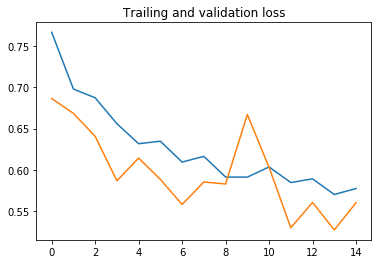

In [73]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')

###### Using google Inception v3 model to do feature extraction

In [75]:
curr_dir = os.getcwd()

inceptionv3_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

urllib.request.urlretrieve(inceptionv3_url,curr_dir + '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')


('/Users/dhensle/Documents/kaggle/google_course/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x1a96686940>)

In [77]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = curr_dir + "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model = InceptionV3(
    input_shape=(150,150,3),
    include_top=False,
    weights=None)
pre_trained_model.load_weights(local_weights_file)

In [79]:
# Making inception model weights not trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [80]:
# Using the 'mixed7' layer of Inception v3 to do the feature extraction (7x7 feature map)
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [81]:
# Appending a fully connected classifier on top of last_output

#Flatten output layer to 1-dim
x = layers.Flatten()(last_output)

# Fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

#Adding dropout layer
x = layers.Dropout(0.20)(x)

#Final output sigmoid classifier
x = layers.Dense(1, activation='sigmoid')(x)

#Configure and compile model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=.0001),
             metrics=['acc'])


In [82]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 74, 74, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_129[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_130

In [83]:
history = model.fit_generator(
    train_generator, #still using image modification from before
    steps_per_epoch=100,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/2
50/50 [==============================] - 53s 1s/step - loss: 0.1657 - acc: 0.9450
 - 230s - loss: 0.5231 - acc: 0.7605 - val_loss: 0.1657 - val_acc: 0.9450
Epoch 2/2
50/50 [==============================] - 49s 987ms/step - loss: 0.2735 - acc: 0.9280
 - 214s - loss: 0.3809 - acc: 0.8300 - val_loss: 0.2735 - val_acc: 0.9280


###### Fine-Tuning Inception V3 model -- setting top layers to be trainable

In [86]:
# Unfreezing all layers belonging to the mixed7 module
from tensorflow.keras.optimizers import SGD

unfreeze = False

for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable=True
    if layer.name=='mixed6':
        unfreeze = True
        
#Using SGD optimizer with very low learning rate
model.compile(loss='binary_crossentropy',
             optimizer=SGD(
                 lr=.00001,
                 momentum=0.9),
             metrics=['acc'])

In [87]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 74, 74, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_129[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_130

In [89]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/50
50/50 [==============================] - 51s 1s/step - loss: 0.2585 - acc: 0.9340
 - 235s - loss: 0.3006 - acc: 0.8695 - val_loss: 0.2585 - val_acc: 0.9340
Epoch 2/50
50/50 [==============================] - 50s 1s/step - loss: 0.2538 - acc: 0.9360
 - 224s - loss: 0.2865 - acc: 0.8765 - val_loss: 0.2538 - val_acc: 0.9360
Epoch 3/50
50/50 [==============================] - 48s 960ms/step - loss: 0.2518 - acc: 0.9360
 - 206s - loss: 0.2855 - acc: 0.8755 - val_loss: 0.2518 - val_acc: 0.9360
Epoch 4/50
50/50 [==============================] - 48s 965ms/step - loss: 0.2510 - acc: 0.9370
 - 204s - loss: 0.2780 - acc: 0.8840 - val_loss: 0.2510 - val_acc: 0.9370
Epoch 5/50
50/50 [==============================] - 46s 928ms/step - loss: 0.2510 - acc: 0.9380
 - 212s - loss: 0.2888 - acc: 0.8755 - val_loss: 0.2510 - val_acc: 0.9380
Epoch 6/50
50/50 [==============================] - 44s 875ms/step - loss: 0.2504 - acc: 0.9370
 - 196s - loss: 0.2757 - acc: 0.8780 - val_loss: 0.2504 - va

50/50 [==============================] - 39s 784ms/step - loss: 0.2386 - acc: 0.9410
 - 172s - loss: 0.2519 - acc: 0.8905 - val_loss: 0.2386 - val_acc: 0.9410
Epoch 50/50
50/50 [==============================] - 39s 785ms/step - loss: 0.2364 - acc: 0.9420
 - 168s - loss: 0.2770 - acc: 0.8785 - val_loss: 0.2364 - val_acc: 0.9420


Text(0.5, 1.0, 'Trailing and validation loss')

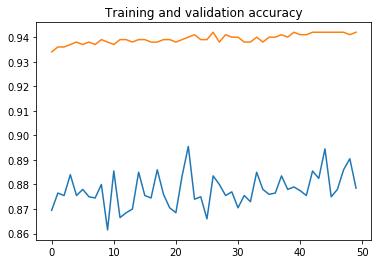

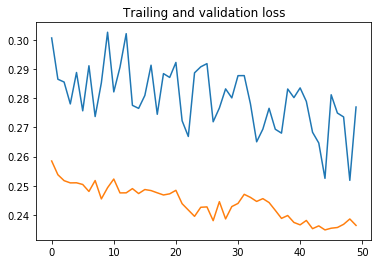

In [90]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')